# Charge station availability forecasting: Required Data

The aim of this notebook is to explore which data we have for our dispose in order to build a model that will allow us to forecast the availability of charge stations. For this we basically have two sources of data. The first one is the historical availability data provided by hubject/smartlab and which is stored in our mongoDB database. The second source of data is our charge stations database (PostgreSQL). We will combine these two in order to get a proper dataset that can be used for our forecasting purposes. Let us start by discussing these data in detail.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Base-data" data-toc-modified-id="Base-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Base data</a></span><ul class="toc-item"><li><span><a href="#Historical-availability-data-(Hubject/smartlab)" data-toc-modified-id="Historical-availability-data-(Hubject/smartlab)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Historical availability data (Hubject/smartlab)</a></span></li><li><span><a href="#Charge-station-/-charge-point-data" data-toc-modified-id="Charge-station-/-charge-point-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Charge station / charge point data</a></span></li><li><span><a href="#merged-data" data-toc-modified-id="merged-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>merged data</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from database import DatabaseHelper

import warnings
warnings.filterwarnings('ignore')

## Base data

### Historical availability data (Hubject/smartlab)

Historical data we get from hubject (mongodb, collection: v2.0.0-chargepoint-status). This data gives the charge point status (AVAILABLE, UNAVAILABLE, INOPERATIVE and UNKNOWN) at a given date. Here the charge point is identified by its evseID.

The table below shows a sniped of such data. Here the plugId is the evseID whereas the service column indicates the data provider (hubject or smartlab). The lastUpdate column gives the information on when was the last time the charge point changed status, and the status column gives the status to which the charge point changed at that time.

In [2]:
cps = [
    'DEALLEGO0030262',
    'DESAEE606502',
    'DEBPEE0FC610101',
    'DEFASE4903501',
    'DEIONE207505',
    'DEALLEGO0025401',
]

data = DatabaseHelper.get_chargepoint_actual_status(cps)
data.head()

plugId              lastUpdate  service       status
0  DEALLEGO0025401 2023-06-14 11:30:02.269  hubject  UNAVAILABLE
1  DEALLEGO0030262 2023-05-26 05:51:05.137  hubject      UNKNOWN
2  DEBPEE0FC610101 2023-05-09 07:36:06.668  hubject    AVAILABLE
3     DEIONE207505 2023-06-09 08:03:06.208  hubject  INOPERATIVE

Currently the oldest data we have available dates from 2021-03-11. So for some charge stations we have about 2 years worth of data.

### Charge station / charge point data

In addition to the historical availability data we have additional information about the charge points and stations. For instance, we have information regarding the plug type (CCS2, TYP2, etc.) location, current, voltage, power, phases among others. This data is stored in our PostgreSQL database.

The table below shows some example of such data for charge station (chargegroup) with id = 36. Here one can see some relevat technical information of all charge points of that station.

In [12]:
query = (
    'SELECT chargegroup_id, "evseId", "plugType", "chargingPower", "chargingVoltage", "chargingCurrent" '
    'FROM station.chargepoints AS cp '
    'JOIN station.chargegroups AS cg ON cg.id = cp.chargegroup_id '
    'WHERE cg.id = 36 ORDER BY "plugType"'
    )

with DatabaseHelper.connect_db() as conn:
    df = pd.read_sql_query(query, conn)

df

chargegroup_id         evseId plugType  chargingPower  chargingVoltage  \
0              36  DEISEE0004769     TYP2           22.0            230.0   
1              36  DEISEE0004978     TYP2           22.0            230.0   
2              36  DEISEE0004908  CHADEMO           50.0            500.0   
3              36  DEISEE0004491  CHADEMO           50.0            500.0   
4              36  DEISEE0004907     CCS2           50.0            500.0   
5              36  DEISEE0004770     CCS2           50.0            500.0   

   chargingCurrent  
0             32.0  
1             32.0  
2            120.0  
3            120.0  
4            120.0  
5            120.0

Now, the first question that needs to be addressed is: what we want to predict actually?. 
In principle, there are two options. The first one is to predict availability of individual charge points. However, this will ignore that at the charge group where the charge point is located there could be other charge points that might, or might not, be available and that can be potentially used. This option increases also the problem complexity since it will be probably necessary to fit a forecasting model for each an every charge point.

For instance, the table below shows the amount of charge points and  charge stations currently (UP TO 01.07.2013) in the Staging environment. In the development instance, we have about 20 times more! 

In [13]:
query = (
    'SELECT COUNT(DISTINCT(id)) AS "chargePoints", COUNT(DISTINCT(chargegroup_id)) AS "chargeGroups" '
    'FROM station.chargepoints'
    )

with DatabaseHelper.connect_db() as conn:
    df = pd.read_sql_query(query, conn)

df

chargePoints  chargeGroups
0         23518          6544

The second option would be to predict an occupancy of charge points at a charge group. The idea is to determine how many of the charge points at the charge group are occupied/available at a given time. Hence, we need to define an occupancy parameter that reflects this. To do this, we need to find out how many charge points are a given charge group. With this, we can estimate the percentage of occupancy at a give time, based on the historical data.

Another important aspect we would like to consider is the parking limitations at charge group. For example, let us consider a charge group (station) that has three charge points, one TYP2 and two CCS2, but has only two parking lots. So if one of the charge points is occupied, the occupancy would be 1/2 and not 1/3. Parking limitation, however, we cannot include in our model since this information is missing in our database.

The table below show some aggregated charge station data. The chargegroup_id is the charge station id. In this table we also have the plug_count which tells us the amount of plugs for a particular plug type that the charge station has. In the table below, we see for instance that each station can have more than one entry, one for each plug Type, e.g., TYP2, CCS, etc. Each entry shows the amount of plugs of the given type at the charge station, also the total amount of plugs (TYP2 + CCS + ...), also we can aggregate some technical information, for instance the maximum charge power of the column, or the average. Finally, there is a list with the charge points evseIds.

In [2]:
cg_df = DatabaseHelper.query_chargegroups()
cg_df.query("chargegroup_id == 36")

chargegroup_id plugType  plug_count  total_plugs  mean_power  \
0              36     TYP2           2          6.0          41   
1              36  CHADEMO           2          6.0          41   
2              36     CCS2           2          6.0          41   

                         evse_ids  
0  [DEISEE0004978, DEISEE0004769]  
1  [DEISEE0004491, DEISEE0004908]  
2  [DEISEE0004770, DEISEE0004907]

### merged data

Alright, we now have the basic data that we need to start searching our search for models to predict station availability. Let us now put this in a single data set or structure by merging them together.

But first we will do some data transformations. 

1. Change status to integer: 
Since we are only interested in predicted if a charge point is available, we will set the status AVAILABLE to 1 and all other to 0. This is justified due to the fact that other statuses out of AVAILABLE just mean that one can not use the charge point, either because it is broken, not available or unknown.

2. Last Update period:
From Hubject we get the last status update date and time. Now since we plan to make predictions on an hourly basis, i.e., we would like to predict the availability each hour. We will need to extrapolate the date time data with an hour period. For the extrapolation we will use what is called a fill forward technique were we the method to impute missing data will be just to used the previous known value. AS an example let us take the case that for a given charge point the last status change was from UNAVAILABLE to AVAILABLE at 02-01-2022 at 12:45. Then it changed again from AVAILABLE to UNAVAILABLE at 2-01-2022 at 16:25. So for this case we have no data between 12:45 and 16:25 we will just forward fill, this will mean that for hours 13, 14 and 15 the status will be the last know which is UNAVAILABLE.

3. Status as an aggregation of available charge points:
Since our aim is to predict availability of charge points of a plug type for a given charge station we will aggregate the amount of charge points of a particular type (e.g., TYP2) that are free at a given hour.

4. Availability
Finally to determined the parameter availability we will just divide the amount of free charge points by the total amount of charge points of the given type.

The table below shows this data merged for a single charge station for plug type CCS2:

In [3]:
cp_df = DatabaseHelper.get_chargepoints()

def merge_data_single_station(cg_df, cp_df, station_id, days=365):
    evse_ids = cg_df.query(f"chargegroup_id == {station_id}").evse_ids.sum()
    data = DatabaseHelper.get_cg_chargepoint_history(evse_ids, days)
    data = (
        data.merge(cp_df, left_on="plugId", right_on="evseId", how="inner")
        .drop("plugId", axis=1)
        )

    return DatabaseHelper.aggregate(data, cg_df)

merged_57 = merge_data_single_station(cg_df, cp_df, station_id=57, days=365)
merged_57.head(10)

lastUpdate plugType  status  chargegroup_id  plug_count  \
0 2023-02-20 10:00:00     CCS2       1              57           3   
1 2023-02-20 11:00:00     CCS2       1              57           3   
2 2023-02-20 12:00:00     CCS2       0              57           3   
3 2023-02-20 13:00:00     CCS2       2              57           3   
4 2023-02-20 14:00:00     CCS2       0              57           3   
5 2023-02-20 15:00:00     CCS2       2              57           3   
6 2023-02-20 16:00:00     CCS2       0              57           3   
7 2023-02-20 17:00:00     CCS2       2              57           3   
8 2023-02-20 18:00:00     CCS2       2              57           3   
9 2023-02-20 19:00:00     CCS2       2              57           3   

   total_plugs  mean_power                                    evse_ids  \
0          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
1          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
2          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
3          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
4          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
5          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
6          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
7          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
8          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   
9          6.0          63  [DEUFCE000551, DEUFCE000022, DEUFCE000021]   

   availability  
0      0.333333  
1      0.333333  
2      0.000000  
3      0.666667  
4      0.000000  
5      0.666667  
6      0.000000  
7      0.666667  
8      0.666667  
9      0.666667

So we see that the lastUpdate column is hourly spaced. Then we see that the status column shows the amount of free CCS2 plugs. Finally we have the availability column that basically tells us the percentage of free charge points.

## Exploratory Data Analysis

Let us now have a look at the data visually. The figure below shows the number of available plugs per plug type for each hour for station with chargegroup_id = 57. The figure shows data just for one day. Here we can see that There are 3 CCS2 plugs at the station, at very early hours in the morning the three plugs are available. At 5AM only one is available, then most of the day, there is always two plugs available. For TYP2, the station has two plugs and they are during this day allways available, except at 6:00 where one of them is being used. On the other hand, the only ChADEMO plug is in the early morning available, then it is being used intermittently until 12:00, then it is not available anymore for the rest of the day.

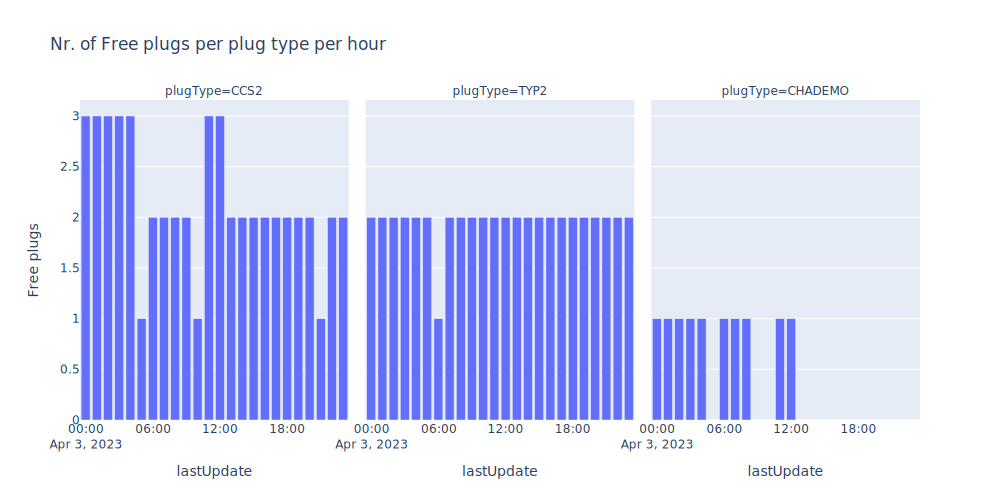

In [6]:
import plotly.io as io
import plotly.express as px

io.renderers.default='svg'

_ = merged_57.set_index("lastUpdate").loc["2023-04-03"].reset_index()
fig = px.bar(
    data_frame=_, x="lastUpdate", y="status", facet_col="plugType",
    labels={
        "status": "Free plugs",
        },
    title="Nr. of Free plugs per plug type per hour",
    width=1000, height=500
            )
fig.show()

However, to standardize the depicted information we will use the availability instead of the number of free plugs. Remember that availability is just the number of available plugs divided by the total amount of plugs of the same type. Here, an availability of 1 (100%) means that all the plugs are available, whereas 0 means none of them are available.
This will look like this:

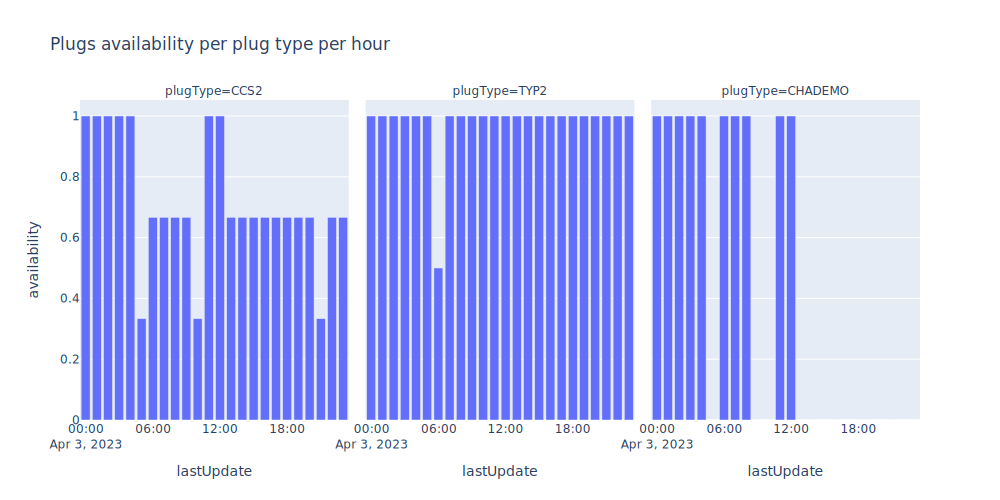

In [8]:
fig = px.bar(
    data_frame=_, x="lastUpdate", y="availability", facet_col="plugType",
    title="Plugs availability per plug type per hour",
    width=1000, height=500,
    )
fig.show()

In [10]:
def get_time_features(df):
    df["month"] = df["lastUpdate"].apply(lambda x: x.month)
    df["weekday"] = df["lastUpdate"].apply(lambda x: x.weekday())
    df["hour"] = df["lastUpdate"].apply(lambda x: x.hour)
    df["weekend"] = merged_57.weekday.apply(lambda x: True if x in [5,6] else False)
    
    return df

merged_57 = get_time_features(merged_57)

If we now add some additional time related columns like the day of the week, if it is a weekend, or the hour, we can do some aggregations an have some further insights into the data. 

The figure belows, show the availability of the CCS2 plugs during two consecutive months. The different colors shows data for working days (blue) and weekends (red). From the figure one can see that the overall behavior during these months are not completely the same, it is actually rather complex. This pattern however is what we would like to forecast.

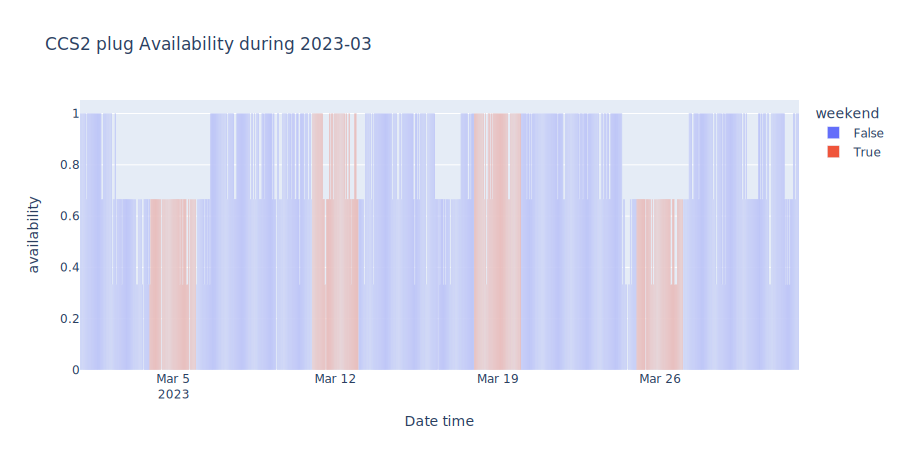

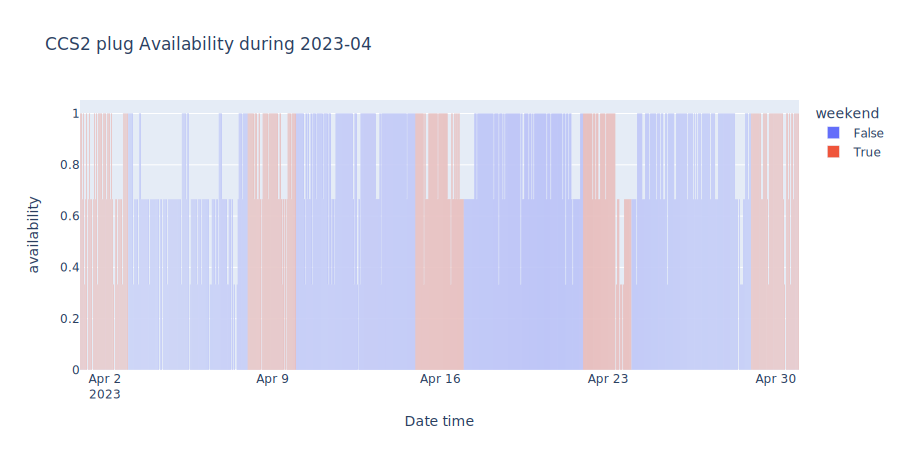

In [12]:
for n in range(3,5):
    date = f"2023-0{n}"
    _ = merged_57.query("plugType == 'CCS2'").set_index("lastUpdate").loc[date].reset_index()
    fig = px.bar(
        data_frame=_, x="lastUpdate", y="availability", color="weekend",
        labels={
            "status": "Free plugs",
            "lastUpdate": "Date time",
            },
        category_orders={
            "weekend": [False, True],
            },
        title=f"CCS2 plug Availability during {date}",
        width=900, height=450,
        )
    fig.show()

From a statistical point of view, we could try to aggregate the data and learn something. As an example, let us have a look, for this particular charge station, at the average hourly plug occupancy and see if there are different patterns. The figure below shows such a plot for the different plug types (rows). The left column shows the average hour availability during working days, whereas the right one shows average availability during weekends.

In general one can see that during the week the CC2 and ChaDeMo plugs availability is in average above 60%. During the middle of the day, between 8:00 and 17:00, the availability slightly decreases. For the TYP2 plugs the availability is most of the time by 80% in average. During the weekends, on the other hand, this pattern is different. We see for instance that for CCS2 and ChaDeMo plugs the availability between 8:00 and 18:00 is lower than during the week. Whereas, for TYP2, the availability is actually higher during the weekend, i.e., above 80%, meaning that for this station, the TYP2 plugs are less used during the weekend than during the day.

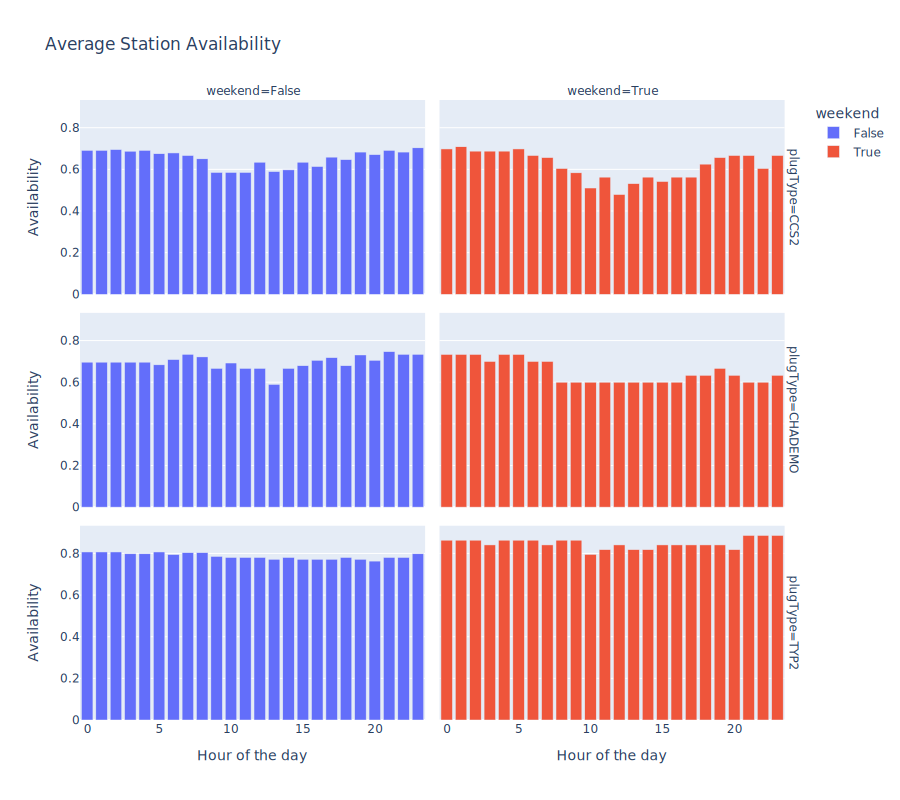

In [16]:
_ = merged_57
_ = _[["availability", "hour", "weekend", "plugType"]].groupby(["weekend", "hour", "plugType"]).mean().reset_index()

fig = px.bar(
    _, x="hour", y="availability", facet_col="weekend", facet_row="plugType",
    color="weekend",
    labels={
        "hour": "Hour of the day",
        "availability": "Availability"
        },
    title="Average Station Availability",
    width=900, height=800,
)
fig.show()

The figure below shows some other examples of average availability for stations where the total amount of plugs is larger than 15.

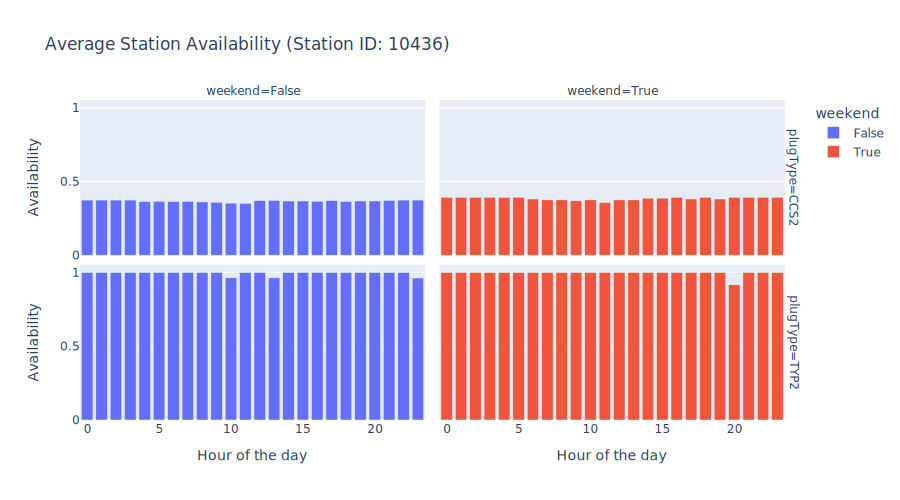

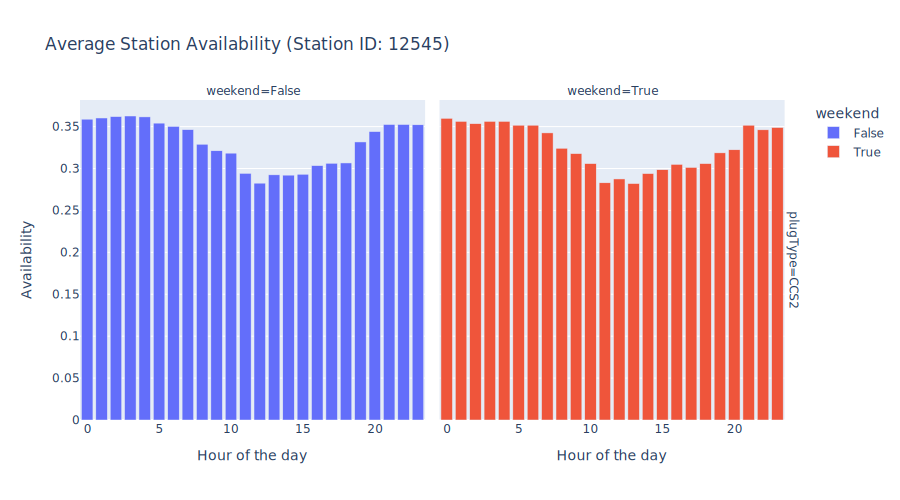

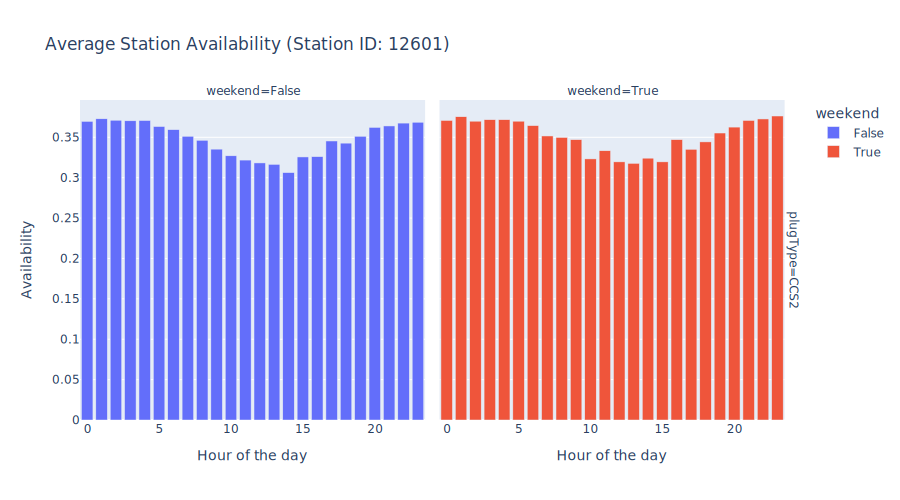

In [18]:
for i in range(6):
    try:
        
        id_ = cg_df.query("total_plugs > 15").chargegroup_id.unique()[i]
        _=merge_data_single_station(cg_df, cp_df, station_id=id_, days=365)
        _ = get_time_features(_)
        _ = _[["availability", "hour", "weekend", "plugType"]].groupby(["weekend", "hour", "plugType"]).mean().reset_index()

        fig = px.bar(
            _, x="hour", y="availability", facet_col="weekend", facet_row="plugType",
            color="weekend",
            labels={
                "hour": "Hour of the day",
                "availability": "Availability"
                },
            title=f"Average Station Availability (Station ID: {id_})",
            width=900, height=500,
            )
        fig.show()
    except Exception as exc:
        continue

We can in principle do some other stuff like finding which is the day and hour of the day where the availability is in average higher or lower. Lest try that for the station with id = 57 and for the CCS2 plugs.

In [120]:
_ =merged_57[["plugType", "availability", "weekday", "hour"]].groupby(["plugType", "weekday", "hour"]).mean()
_=_.loc["CCS2"]
_ = pd.concat(
    [
        _.query(f"availability == {_.availability.max()}"),
        _.query(f"availability == {_.availability.min()}"),
    ], axis=1
).fillna("")
_.columns = ["Max Availability", "Min. Availability"]
_

Max Availability Min. Availability
weekday hour                                   
2       7            0.764706                  
5       12                             0.458333
6       10                             0.458333
        15                             0.458333

The table above shows the day and hour of the day where the availability is max and min. So the max availability for this station is in average 76% on day 2 (Wednesday) at 7:00. Minimum availability, about 45% takes place during the weekend (day 5 and 6, i.e., Saturday and Sunday) around midday.

## Summary

In the present notebook we have explore the available data that we have that we can use to build a plug availability forecasting model. We have seen that basically there are two sources of data, one historical availability from Hubject/smartlab and the other is our charge station database. 

During our exploration we have discussed the possibility to forecast the availability of a single charge point or the availability of a given plugType in terms of the total amount of plugs of the type at a given station. With this we concluded that perhaps in terms of reducing complexity, it will be better to use a plug type availability model.

Going in this direction we have come up with a dataset where we aggregate the data hourly for each charge station and plug types. Additionally, we have perform a quick look at the data and explore for some particular examples (charge stations) how the availability varies with time. We have also perform some simple statistical analysis and have seen how the average availability varies hour dependent on the plug type and whether the it is a weekend or a working day.